In [2]:

import warnings
import sys
print(sys.executable)
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
# from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)

# api = StatsBombLoader(getter="remote", creds=None)
from statsbombpy import sb 

df = pd.read_csv("All_events_labeled.csv")
df.head()


c:\Users\Areen\miniconda3\envs\soccer_data\python.exe


C:\Users\Areen\AppData\Local\Temp\ipykernel_54564\2028828985.py:16: DtypeWarning: Columns (0,2,3,4,6,7,8,9,10,11,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,34,39,45,46,48,50,53,57,59,60,72,73,74,75,76,77,78,80,81,82,84,86,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("All_events_labeled.csv")


KeyboardInterrupt: 

I want to predict: P(goal | after action) – P(goal | before action): Conditional Probability, how the probability of an event changes given a certain condition

How much a specific action, pass; dribble, increases the likelihood that the team's chance of scoring a goal
 - Compares to the state of play Just BEFORE the action was taken

For example: Does a goal happen within the next 5 action? THIS BECOMES THE TARGET VARIABLE



In [ ]:
df.fillna(0, inplace = True)
print("Shape: ", df.shape)
print("\n")

# print("Null values per columns: ")
# print(df.isnull().sum())

df["goal_next_5"] = (
    df.groupby('match_id')['goal_occurred'] # GROUPS THE EVENT DATA AND SELECTS THE COLUMNS GOAL_OCCURED = TRUE
    # PROCESSES EACH MATCH'S EVENTS SEPARATELY

    .shift(-1)  # SHIFTS THE COLUMNS BACKWARD BY 1 SO THAT EACH ACTION "LOOKS AHEAD" AT WHAT HAPPENS AFTER IT
    # ACTIONS AT INDEX "i" NOW GETS THE GOAL LABEL FROM INDEX I+1

    .rolling(5, min_periods=1) # APPLY ROLLING WINDOW OF SIZE 5 (I.E, LOOKAHEAD WINDOW OF THE NEXT 5 ACTIONS)
    # 5 = WINDOW SIZE, MIN PERIODS = 1 MEANS ITLL COMPUTE EVEN IF FEWER THAN 5 ROWS LEFT IN THE MATCH

    .max() # TAKES THE MAXIMUM VALUE WITHIN EACH ROLLING WINDOW, SO IF ANY OF THE NEXT 5 ACTIONS HAVE A 
    # GOAL OCCURED == TRUE, THE CURRENT ACTION GETS LABELED AS 1

    .fillna(False) # SOME ACTIONS (NEAR THE END OF A MATHCH) MAY NOT HAVE ENOUGH FUTURE ACTIONS, THIS REPLACES
    # NAN WITH FALSE

    .astype(int) # CONVERTS FINAL BOOLEAN VALUES TO INTEGERS

   # For index 0: next actions = 1, 2, 3, 4, 5 → goal at index 3 → label = 1

   # For index 1: next actions = 2, 3, 4, 5 → goal at index 3 → label = 1

   # For index 2: next actions = 3, 4, 5 → goal at 3 → label = 1

   # For index 3: next actions = 4, 5 → NO goal → label = 0

   # For index 4, 5: no goal → label = 0
)

actions_of_interest = [
    "Pass", "Carry", 'Shot', 'Dribble', 'Duel', 'Ball Receipt', 'Interception', 'Clearance'
]

df_clean = df[df["type"].isin(actions_of_interest)]

cols_to_keep = [
    'match_id', 'player_id', 'team_id', 'period', 'minute', 'second',
    'type', 'x', 'y', 'pass_end_x', 'pass_end_y', 'carry_end_x', 'carry_end_y',
    'xg_total', 'under_pressure', 'possession', 'possession_team', 'goal_next_5'
]

df_model = df_clean[cols_to_keep].copy()

df_model = df_model.fillna(0)

#Encoding
categorical_cols = ['type', 'under_pressure', 'period', 'possession_team']

df_model = pd.get_dummies(df_model, columns=categorical_cols, dummy_na=True)

print(df_model.select_dtypes(include='object').columns)

print("Shape: ", df_model.shape)
print(df_model.head(10))

Shape:  (1052932, 145)


Index([], dtype='object')
Shape:  (588546, 65)
    match_id  player_id  team_id  minute  second     x     y  pass_end_x  \
6      22912     3532.0       24       0       0  61.0  40.1        34.0   
7      22912     3502.0       24       0       3  36.1  44.0        86.6   
8      22912     3308.0       38       0       5  33.5  76.6        54.5   
9      22912     3247.0       24       0       7  65.6  14.2        82.8   
10     22912     3091.0       38       0       8  37.3  63.0        44.9   
11     22912     3532.0       24       0      10  75.2  19.4        86.4   
12     22912    20005.0       38       0      11  33.7  59.8        60.6   
13     22912     3669.0       24       0      14  59.5  19.6        65.4   
14     22912     3567.0       24       0      16  64.7  18.4        64.9   
15     22912     3532.0       24       0      17  64.3  24.3        99.2   

    pass_end_y  carry_end_x  ...  possession_team_Real Madrid  \
6         43.8          0.

Training the Model: Thinking LightGBM (Light Gradient Boosting Machine), Strong: Speed, Memory Efficiency, Accuracy
 - Sequentially adding weak learners in a gradient descent manner

LightGBM:
Ensemble ot decision trees, each tree tries to *fix the mistakes* of the last one

1. Train a small tree to make predictions
2. Look at where its wrong (residual errors)
3. Train a new tree to predict those errors
4. Repear - Adding each new tree's correlations to the previous predictions
5. Stop when performacne stops improving (or after N rounds)

Boosts itself step by step

IF type == 'Pass' AND x > 60 AND under_pressure == False THEN ↑↑↑ P(goal)
 - Builds a forest of these tiny rule sets that together learn:
  - Which kinds of actions increase the chance of scoring soon?"

In [ ]:
import sys
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15700, number of negative: 455136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4428
[LightGBM] [Info] Number of data points in the train set: 470836, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033345 -> initscore=-3.366936
[LightGBM] [Info] Start training from score -3.366936
Unique labels: [0 1]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113675
           1       0.75      0.68      0.71      4035

    accuracy                           0.98    117710
   macro avg       0.87      0.83      0.85    117710
weighted avg       0.98      0.98      0.98    117710

ROC AUC: 0.9

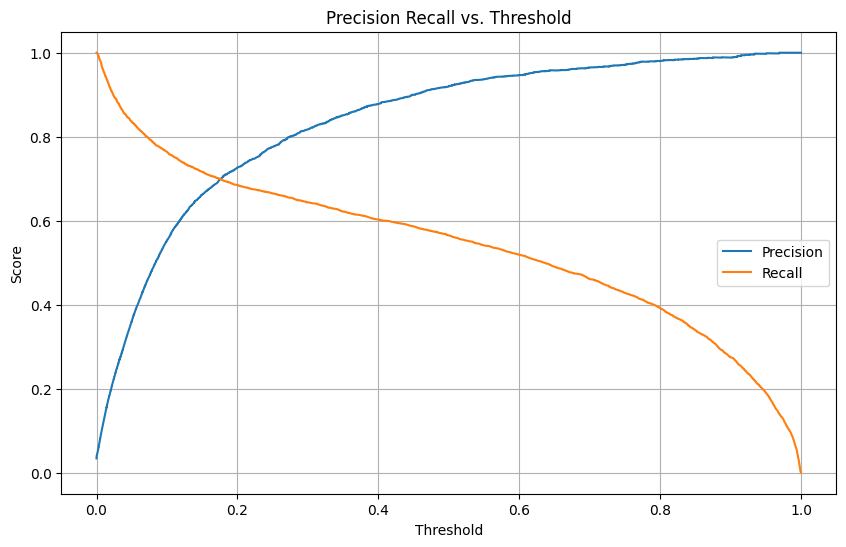

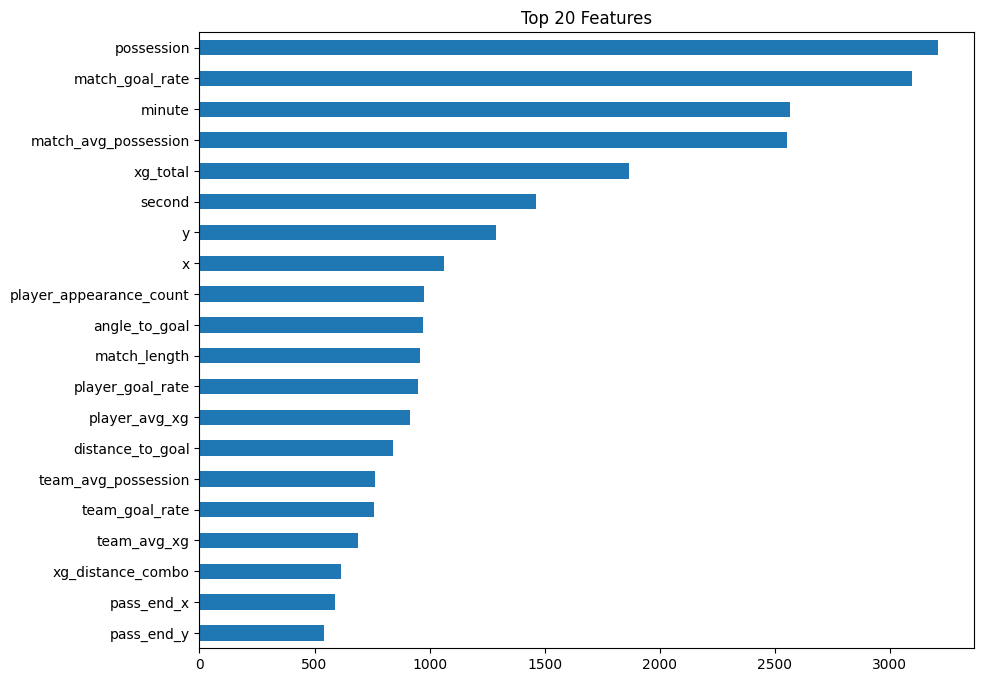

In [ ]:
# INSTEAD OF USING RAW PLAYER IDS (CAUSES OVERFITTING)
# AGGREGATE PER-PLAYER STATISTICS THAT GENERALIZE BETTER

player_agg = df_model.groupby('player_id').agg({
    'xg_total':'mean', # AVERAGE XG THE PLAYER GENERATES PER EVENT
    'goal_next_5': ['mean', 'count'] # % OF TIMES THAT THE PLAYER TRIGGERS A GOAL IN 
    # THE NEXT 5 EVENTS, AND APPEARANCES
}).reset_index()

# RENAME COLUMNS FOR CLARITY
player_agg.columns = ['player_id', 'player_avg_xg', 'player_goal_rate', 'player_appearance_count']

# MERGE BACK TO MAIN DATASET
df_model = df_model.merge(player_agg, on = 'player_id', how='left')

# REMOVE RAW TEAM ID AND REPLACE WITH MEANINGFUL TEAM WIDE PATTERNS
# THESE HELP CAPTURE TEAM ATTACKING TENDENCIES WITHOUT RELYING ON TEAM IDENTITY ALONE
team_agg = df_model.groupby('team_id').agg({
    'xg_total':'mean', # AVG XG FOR THE TEAM OVERALL
    'goal_next_5': 'mean', # AVG GOAL CONVERSION RATE FOR THE TEAM
    'possession' : 'mean' # AVERAGE POSSESSION PER EVENT FOR THE TEAM
}).reset_index()

team_agg.columns = ['team_id', 'team_avg_xg', 'team_goal_rate', 'team_avg_possession']

df_model = df_model.merge(team_agg, on='team_id', how='left')

# THIS ADDS OVERALL MATCH CONTEXT (E.G. MATCH TEMP, AVERAGE ATTACKING QUALITY)
# WHILE AVOIDING MEMORIZING MATCH IDS
match_agg = df_model.groupby('match_id').agg({
    'minute': 'max',              # TOTAL LENGTH OF MATCH
    'goal_next_5': 'mean',        # HOW 'OPEN' OR ATTACKING THE MATCH WAS
    'possession': 'mean'          # AVERAGE POSSESSION LEVEL IN THE MATCH
}).reset_index()

match_agg.columns = ['match_id', 'match_length', 'match_goal_rate', 'match_avg_possession']

df_model = df_model.merge(match_agg, on='match_id', how='left')

# SPATIAL FEATURES
df_model['distance_to_goal'] = np.sqrt((120 - df_model['x'])**2 + (40 - df_model['y'])**2).astype(float) # EUCLIDEAN DISTANCE FROM (X, Y) TO A CENTER OF GOAL AT (120, 40)

# ANGLE TO GOAL
def calculate_angle_to_goal(x, y):
    try:
        a = np.sqrt((120 - x)**2 + (44 - y)**2)
        b = np.sqrt((120 - x)**2 + (36 - y)**2)
        c = 8  # goal width in StatsBomb coords

        numerator = a**2 + b**2 - c**2
        denominator = 2 * a * b

        cos_angle = np.clip(numerator / denominator, -1, 1)
        return float(np.arccos(cos_angle))
    except:
        return np.nan

df_model['angle_to_goal'] = df_model.apply(lambda row: calculate_angle_to_goal(row['x'], row['y']), axis=1)
df_model['angle_to_goal'] = pd.to_numeric(df_model['angle_to_goal'], errors='coerce')


scaler = MinMaxScaler()
df_model[['distance_to_goal', 'angle_to_goal']] = scaler.fit_transform(df_model[['distance_to_goal', 'angle_to_goal']])

df_model['distance_to_goal'] = pd.to_numeric(df_model['distance_to_goal'], errors='coerce')
df_model['angle_to_goal'] = pd.to_numeric(df_model['angle_to_goal'], errors='coerce')

df_model.dropna(subset=['distance_to_goal', 'angle_to_goal'], inplace=True)

df_model['xg_distance_combo'] = df_model['xg_total'] * df_model['distance_to_goal']

df_model.drop(columns=['match_id', 'team_id', 'player_id'], errors='ignore', inplace=True)

# SPLIT FEATURES/TARGET
X = df_model.drop(columns=["goal_next_5"])
Y = df_model["goal_next_5"]

# TEST/TRAIN SPLIT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_test = Y_test.astype(int)

# MODEL
model = LGBMClassifier(
    subsample=1.0,
    num_leaves=31,
    n_estimators=1000,
    max_depth=-1,
    learning_rate=0.1,
    colsample_bytree=0.9
)

model.fit(X_train, Y_train)

# PREDICT
y_pred = model.predict(X_test)

# Extract positive class prob
y_probs = model.predict_proba(X_test)[:, 1]

optimal_thresh = 0.22 # SET OPTIMAL THRESHOLD

precision, recall, thresholds = precision_recall_curve(Y_test, y_probs)

y_pred_adjusted = (y_probs >= optimal_thresh).astype(int)

# Confirm binary targets
print("Unique labels:", np.unique(Y_test))

# EVALUATE
print(classification_report(Y_test, y_pred_adjusted))

# Calculate ROC AUC
print("ROC AUC:", roc_auc_score(Y_test, y_probs, multi_class='ovr'))

#Plot to visualize trde-off
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label = 'Precision')
plt.plot(thresholds, recall[:-1], label = 'Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# PLOT FEATURE IMPORTANCE
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(20).plot(kind = 'barh', figsize=(10, 8))
plt.title("Top 20 Features")
plt.gca().invert_yaxis()
plt.show()


c:\Users\Areen\miniconda3\envs\soccer_data\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Areen\miniconda3\envs\soccer_data\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<class 'numpy.ndarray'>
Single array SHAP values shape: (117710, 73)


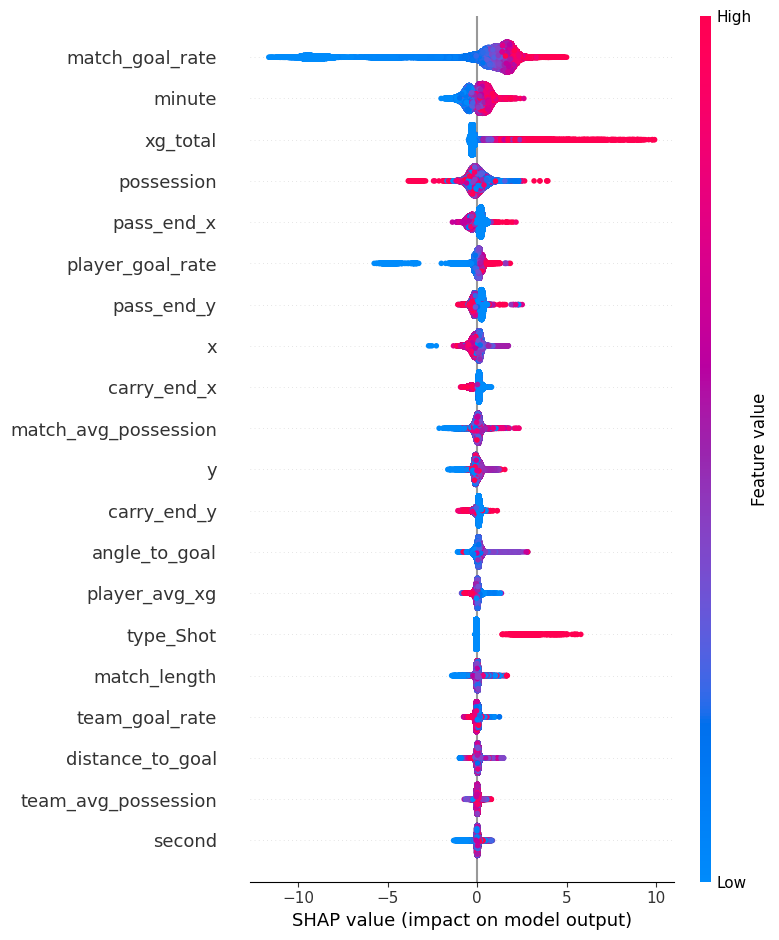

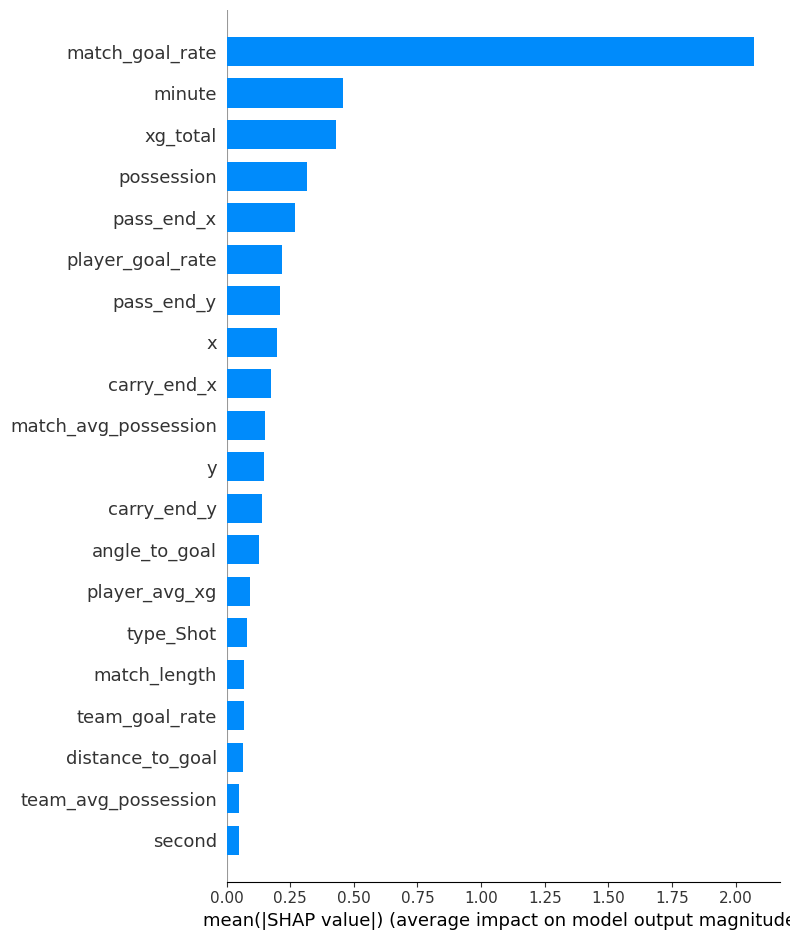

In [ ]:
import shap

# CREATE TREE EXPLAINER FOR LIGHTGBM MODEL (replace `model` with your actual variable name if different)
explainer = shap.TreeExplainer(model)  # Make sure clf is your trained LightGBM model

# COMPUTE SHAP VALUES FOR TEST DATA
shap_values = explainer.shap_values(X_test)

print(type(shap_values))
if isinstance(shap_values, list):
    print("Binary classifier detected. SHAP values returned as list of arrays.")
    print("Class 0 SHAP shape:", shap_values[0].shape)
    print("Class 1 SHAP shape:", shap_values[1].shape)
else:
    print("Single array SHAP values shape:", shap_values.shape)


# SUMMARY PLOT: Shows feature impact and direction toward class 0 or 1
shap.summary_plot(shap_values, X_test)

# (Optional) BAR PLOT: Just average absolute SHAP values per feature
shap.summary_plot(shap_values, X_test, plot_type='bar')

# (Optional) FORCE PLOT FOR ONE INSTANCE: Visualize how each feature affects a single prediction
shap.initjs()
shap.force_plot(
    explainer.expected_value,  # Base value for class 1 (goal)
    shap_values[0],            # SHAP values for first sample in class 1
    X_test.iloc[0]                # Feature values for first test sample
)


EDA

Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot',
       ...
       'end_type', 'end_x', 'end_y', 'sequence_length', 'num_passes',
       'num_shots', 'xg_total', 'shot_outcome_seq', 'goal_occurred',
       'goal_next_5'],
      dtype='object', length=146)


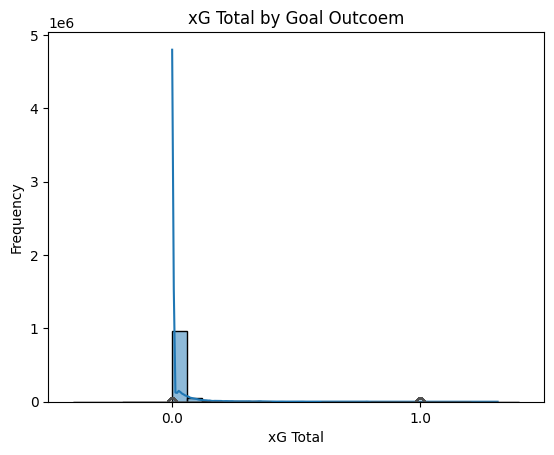

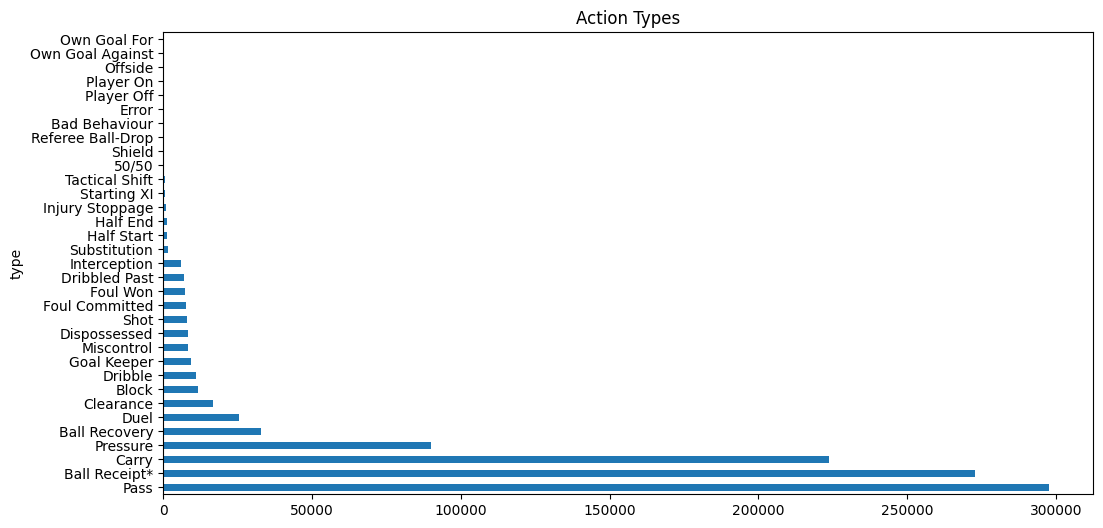

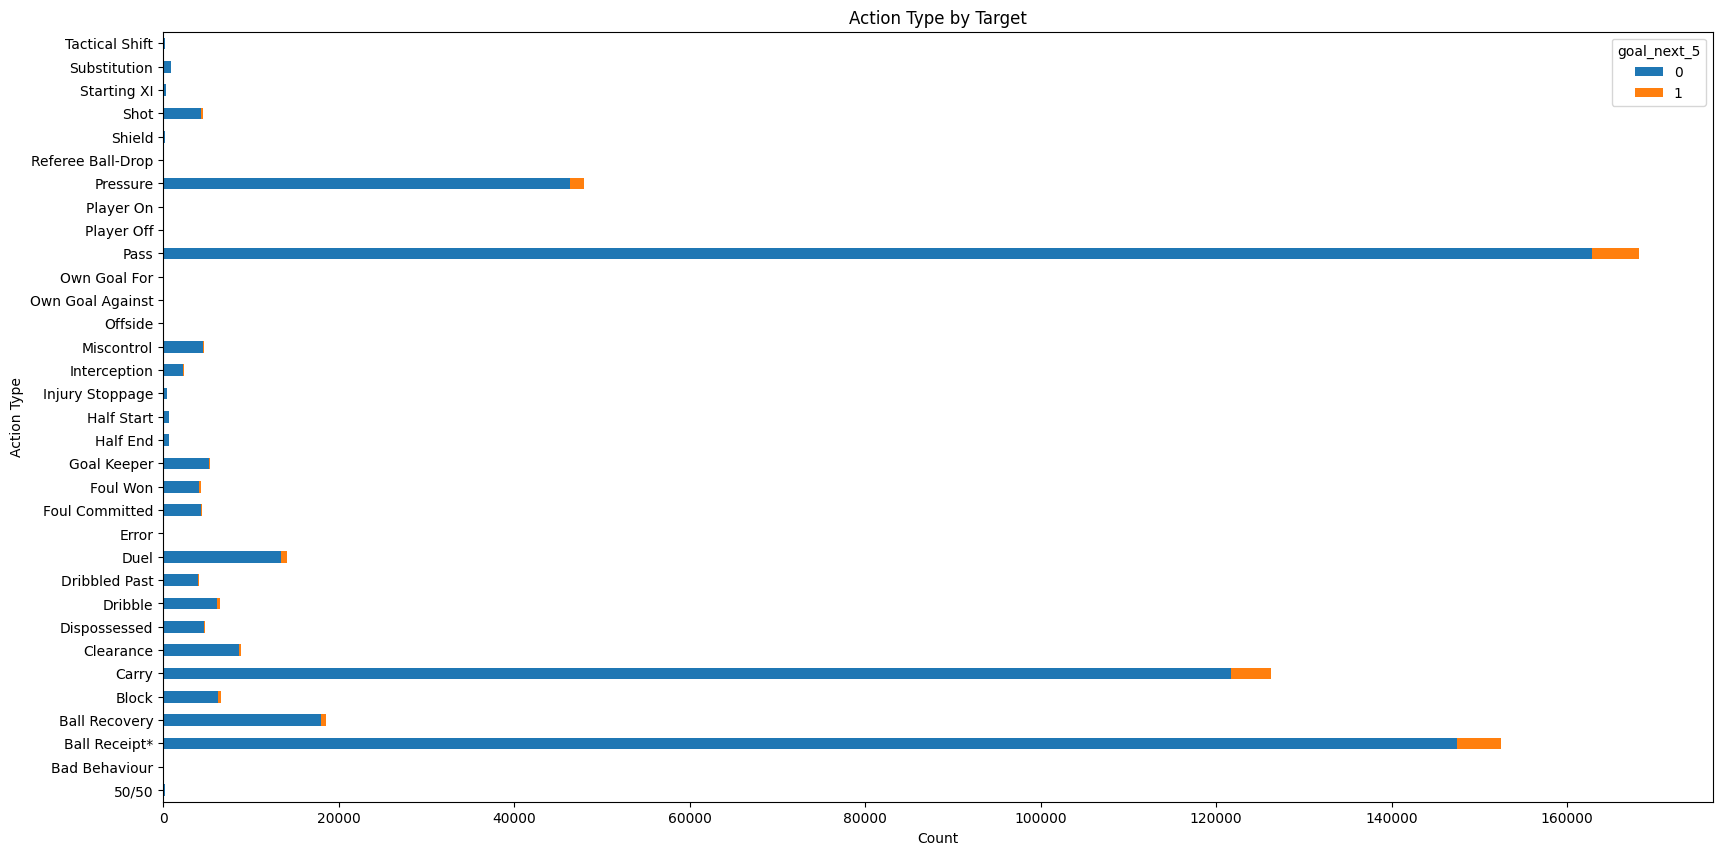

In [ ]:
print(df.columns)

# xG DISTRIBUTION
sn.histplot(df['xg_total'], kde=True)
plt.title('Distribution of xG Total')
plt.xlabel("xG Total")
plt.ylabel("Frequency")


# COMPARE BY TARGET
sn.boxplot(x=Y, y=df['xg_total'])
plt.title('xG Total by Goal Outcoem')


plt.figure(figsize=(12, 6))
df['type'].value_counts().plot(kind='barh', title='Action Types')

pd.crosstab(df['type'], Y).plot(kind='barh', stacked=True, figsize=(20, 10))
plt.title('Action Type by Target')
plt.xlabel('Count')
plt.ylabel('Action Type')
plt.show()
